## Hidden loop experiment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import normaltest
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.optimize import minimize
from pathlib import Path
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

%cd ..

/Users/andrey/MIPT_projects/M1P_6_sem/2023-Project-119


In [2]:
plt.rc('axes', titlesize=25, titleweight='bold') #fontsize of the title
plt.rc('axes', labelsize=20) #fontsize of the x and y labels
plt.rc('xtick', labelsize=20) #fontsize of the x tick labels
plt.rc('ytick', labelsize=20) #fontsize of the y tick labels
plt.rc('legend', fontsize=25) #fontsize of the legend
plt.rc('figure', figsize=(12, 8)) # figure size

### Defining usage and adherence

In [30]:
usage = 1
adherence = 0

### Preparing data

In [31]:
# preparing our data
hidden_loops = Path(f"results/hidden_loops_ee_{usage}_{adherence}")
p_values = []
f_t_list = []
steps = range(10, 1251, 10)

for folder in sorted(hidden_loops.iterdir()):
    if folder.name != '.DS_Store':
        for step in steps:
            data = pd.read_csv(f"{hidden_loops}/{folder.name}/deviations/ridge-dev_step_{step}.csv")
            data_hist = data['y'] - data['y_pred']
            hst = np.histogram(data_hist, density=True, bins=200)
            f_t = interp1d(hst[1][:-1], hst[0], kind='linear', 
                           fill_value=0.0, bounds_error=False)
            _, p_value = normaltest(data['y'] - data['y_pred'])
            f_t_list.append(f_t)
            p_values.append(p_value)

In [32]:
# preparing f_t(0) and int_{-kappa}^{kappa}f_t(x)dx
f_t0_list = []
integrals = {}
kappas = [0.1, 0.2, 0.3]

for kappa in kappas:
    integrals[kappa] = []
for f_t in f_t_list:
    f_t0_list.append(float(f_t(0.)))
    for kappa in kappas:
        integral, _ = quad(f_t, -kappa, kappa)
        integrals[kappa].append(min(integral, 1.0))

### Normatity test

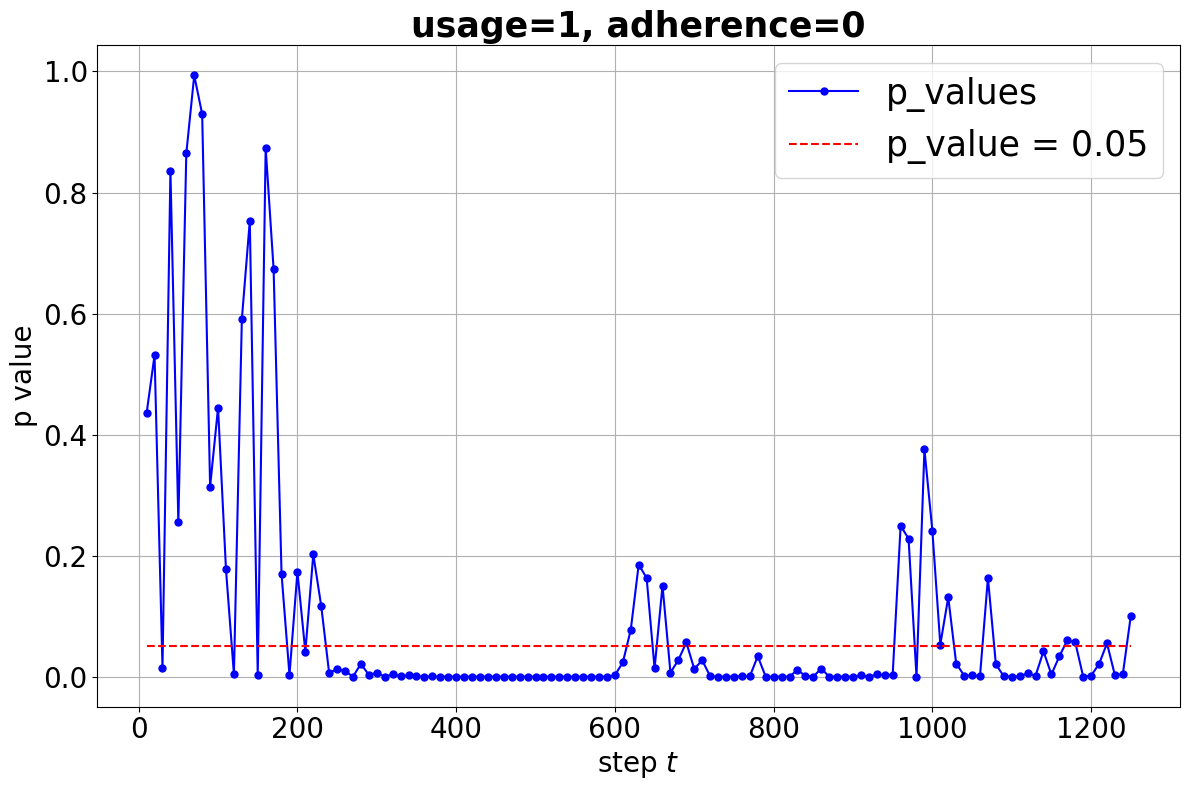

In [7]:
# plot p_values
plt.title(f"usage={usage}, adherence={adherence}")

plt.xlabel(r"step $t$")
plt.ylabel("p value")

plt.plot(steps, p_values, label = "p_values", 
           color="blue", marker='o', markersize=5)
plt.plot(steps, [0.05]*len(steps), '--', color="red", label="p_value = 0.05")

plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig(f"figures/p_loop_{usage}_{adherence}.png")
plt.show()

### Making hists

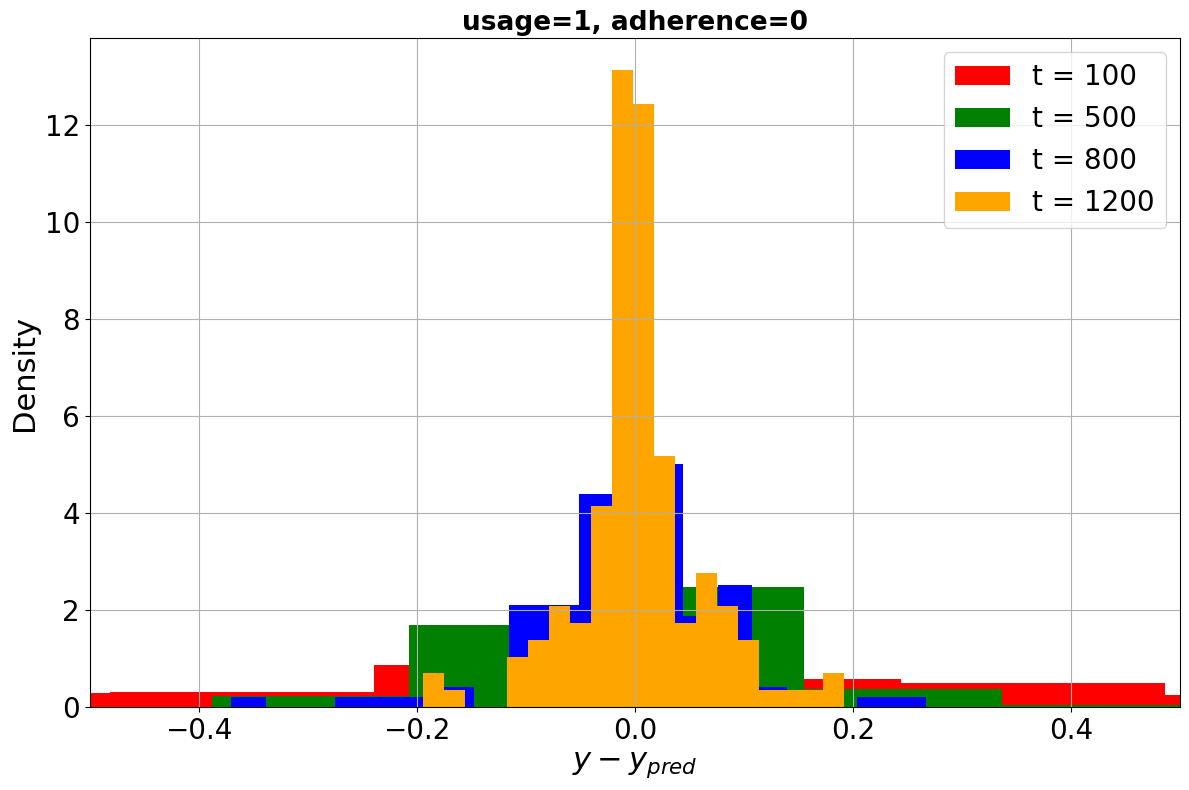

In [9]:
# plot histograms
plt.figure(figsize=(12, 8))
plt.title(f"usage={usage}, adherence={adherence}",
          fontsize=19, fontweight='bold')
plt.xlabel(r"$y - y_{pred}$", fontsize=22)
plt.ylabel("Density", fontsize=22)
plt.xlim((-0.5, 0.5))

colors = ['red', 'green', 'blue', 'orange', 'purple',
          'cyan', 'pink', 'brown', 'black', 'olive']

steps_hist = [100, 500, 800, 1200]
for folder in sorted(hidden_loops.iterdir()):
    if folder.name != '.DS_Store':
        for step, color in zip(steps_hist, colors):
            data = pd.read_csv(f"{hidden_loops}/{folder.name}/deviations/ridge-dev_step_{step}.csv")
            data_hist = np.array(data['y'] - data['y_pred'])
            hst = np.histogram(data_hist, density=True, bins=500)
            plt.hist(data_hist, bins=20, label=f"t = {step}", color=color,
                     density=True, stacked=True)
            f_t = interp1d(hst[1][:-1], hst[0], kind='cubic', 
                           fill_value=0.0, bounds_error=False)
            x_axis = np.linspace(-0.5, 0.5, 3000)
            #plt.plot(x_axis, f_t(x_axis), label=f"t = {step}", color=color)

plt.legend(fontsize=20)
plt.grid()
plt.tight_layout()
#plt.savefig(f"figures/hist_loop_{usage}_{adherence}.png")
plt.show()

### Limit to delta function

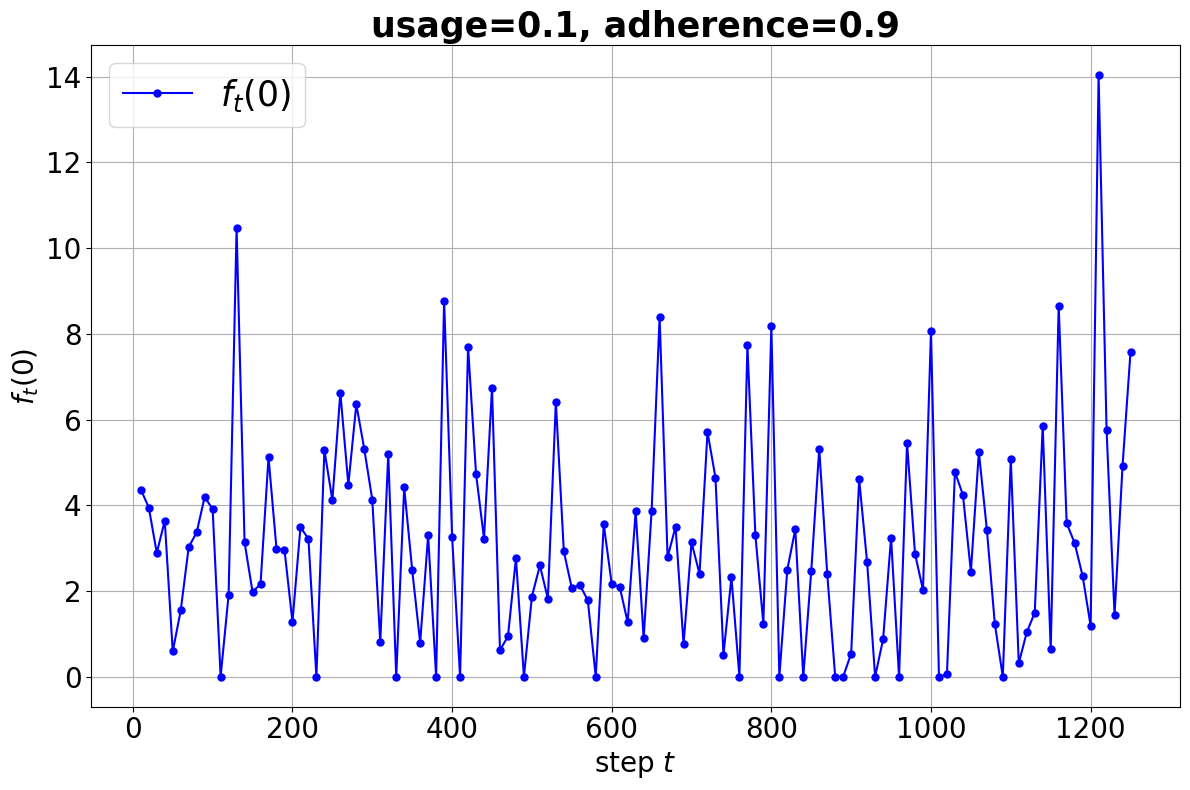

In [34]:
# plot f_t(0)
plt.title(f"usage={usage}, adherence={adherence}")
plt.xlabel(r"step $t$")
plt.ylabel(r"$f_t(0)$")
plt.plot(steps, f_t0_list, label = r"$f_t(0)$", 
         color="blue", marker='o', markersize=5)
plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig(f"figures/ft0_loop_{usage}_{adherence}.png")
plt.show()

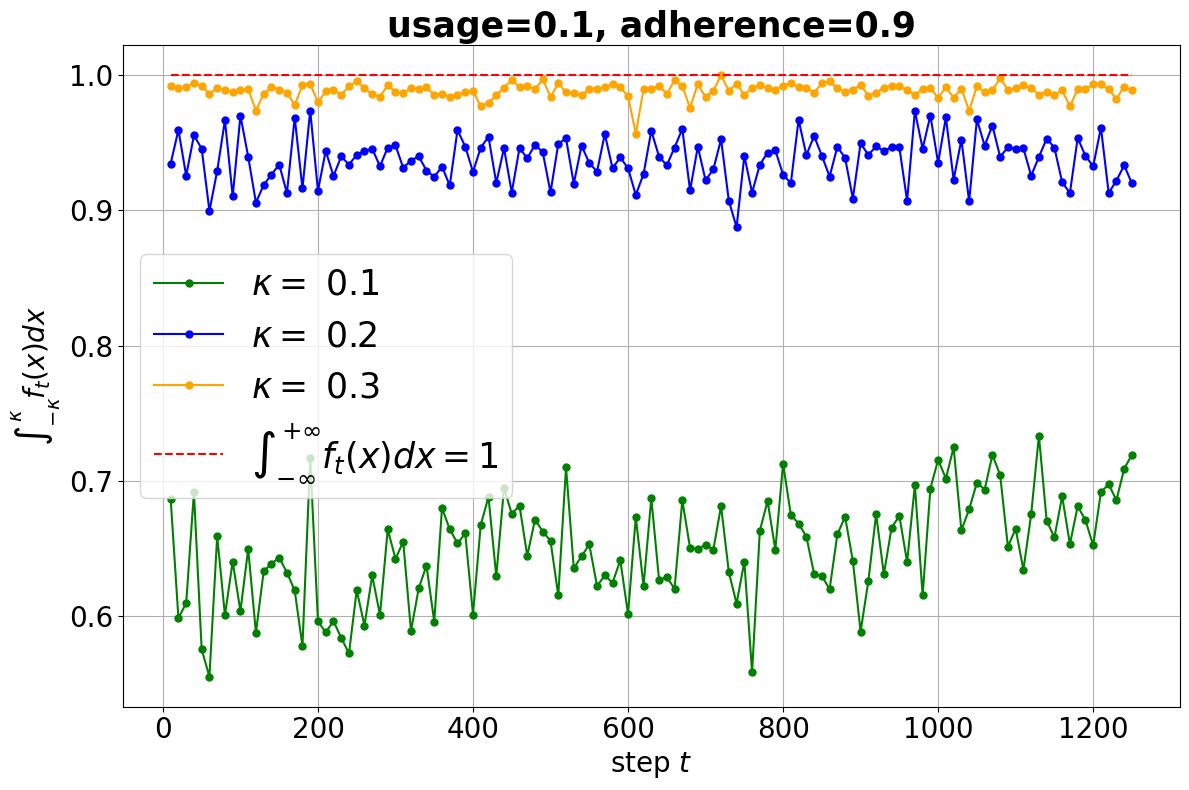

In [35]:
# plot int_{-kappa}^{kappa}f_t(x)dx
plt.title(f"usage={usage}, adherence={adherence}")
plt.xlabel(r"step $t$")
plt.ylabel(r"$\int_{-\kappa}^{\kappa}f_t(x)dx$")

colors = ['green', 'blue', 'orange']
for kappa, color in zip(integrals.keys(), colors):
    plt.plot(steps, integrals[kappa],
             label = r"$\kappa = $ %.1f" % kappa,
             color=color, marker='o', markersize=5)
plt.plot(steps, [1]*len(steps), '--', color="red",
         label=r"$\int_{-\infty}^{+\infty}f_t(x)dx = 1$")
plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig(f"figures/int_loop_{usage}_{adherence}.png")
plt.show()

### Semigroup chek

In [13]:
# Robust loss function
alpha = 0.01
eps = 1.35
def huber_loss_func(X, y, w, sigma):
    def H_eps(z):
        if np.abs(z) < eps:
            return z**2
        else:
            return 2 * eps * np.abs(z) - eps**2

    Sum = 0. 
    for x_i, y_i in zip(X, y):
        Sum += sigma + H_eps((x_i * w[0] + w[1] - y_i) / sigma) * sigma
    return Sum + alpha * (w[0]**2 + w[1]**2)

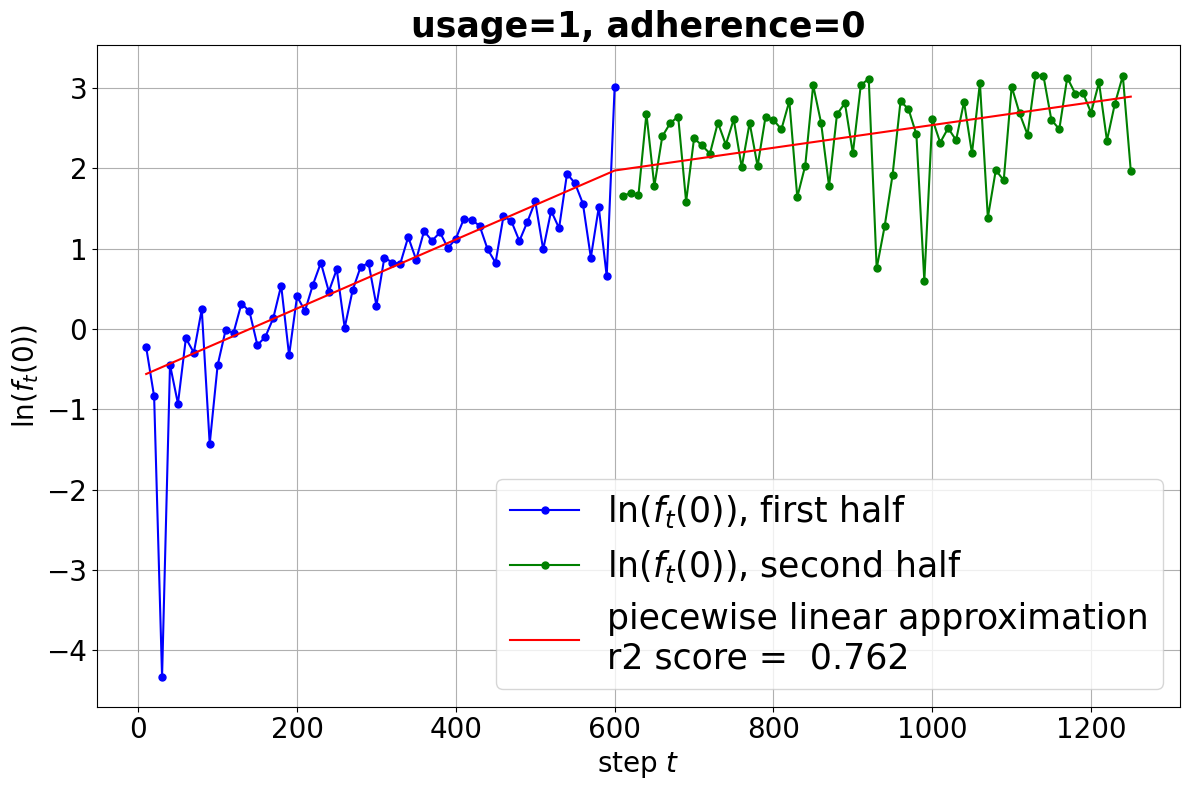

In [15]:
# plot ln(f_t(0)) 
plt.title(f"usage={usage}, adherence={adherence}")

t_inter = 600.
steps = np.array(steps)
log_1 = np.log(f_t0_list)[steps <= t_inter]
log_2 = np.log(f_t0_list)[steps > t_inter]

plt.xlabel(r"step $t$")
plt.ylabel(r"$\ln(f_t(0))$")
plt.plot(steps[steps <= t_inter], log_1, label = r"$\ln(f_t(0))$, first half", 
         color="blue", marker='o', markersize=5)
plt.plot(steps[steps > t_inter], log_2, label = r"$\ln(f_t(0))$, second half", 
         color="green", marker='o', markersize=5)

def function(x):
    k1, b1, k2, b2, sigma = x

    loss_1 = huber_loss_func(steps[steps <= t_inter], log_1, (k1, b1), sigma)
    loss_2 = huber_loss_func(steps[steps > t_inter], log_2, (k2, b2), sigma)
    return loss_1 + loss_2

constr = ({'type' : 'eq', 'fun' : lambda x : (x[0] - x[2]) * t_inter - x[3] + x[1]},
          {'type' : 'ineq', 'fun' : lambda x : x[4] - 1e-11})

res = minimize(function, (0, 0, 0, 0, 1), constraints=constr)
k1, b1, k2, b2, sigma = res.x

first = k1 * steps[steps <= t_inter] + b1
second = k2 * steps[steps > t_inter] + b2
r2score = r2_score(np.hstack((log_1, log_2)), np.hstack((first, second)))

plt.plot(steps, np.hstack((first, second)), '-', color='red', 
         label='piecewise linear approximation\nr2 score =  %.3f' % r2score)

plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig(f"figures/semigroup_loop_{usage}_{adherence}.png")
plt.show()

In [18]:
# test for heteroscedasticity
tol = 1.
err = (np.hstack((log_1, log_2)) - np.hstack((first, second)))**2
residuals = (np.hstack((log_1, log_2)) - np.hstack((first, second)))[err <= tol]
x = steps[err <= tol]

_, p_val, _, _ = het_breuschpagan(residuals, list(zip(np.ones_like(x), x)))

print(f'p_value = %.3f, homoscedasticity: {p_val < 0.05}' % p_val)
# mse
print('mse = %.3f' % mse(np.hstack((log_1, log_2)), np.hstack((first, second))))

p_value = 0.016, homoscedasticity: True
mse = 0.347


### Moments

In [19]:
# functions to calculate k-th moments
def k_moment(k, func):
    new_func = lambda x : (x**k) * func(x)
    integral, _ = quad(new_func, -np.inf, np.inf)
    return integral

In [20]:
# preparing ||moment_k^t||_1
l1_norms = []
N = 150
for f_t in f_t_list:
    l1_norm = 0
    for k in range(1, N+1):
        try:
            l1_norm += np.abs(k_moment(k, f_t))
        except OverflowError:
            pass
    l1_norms.append(l1_norm)

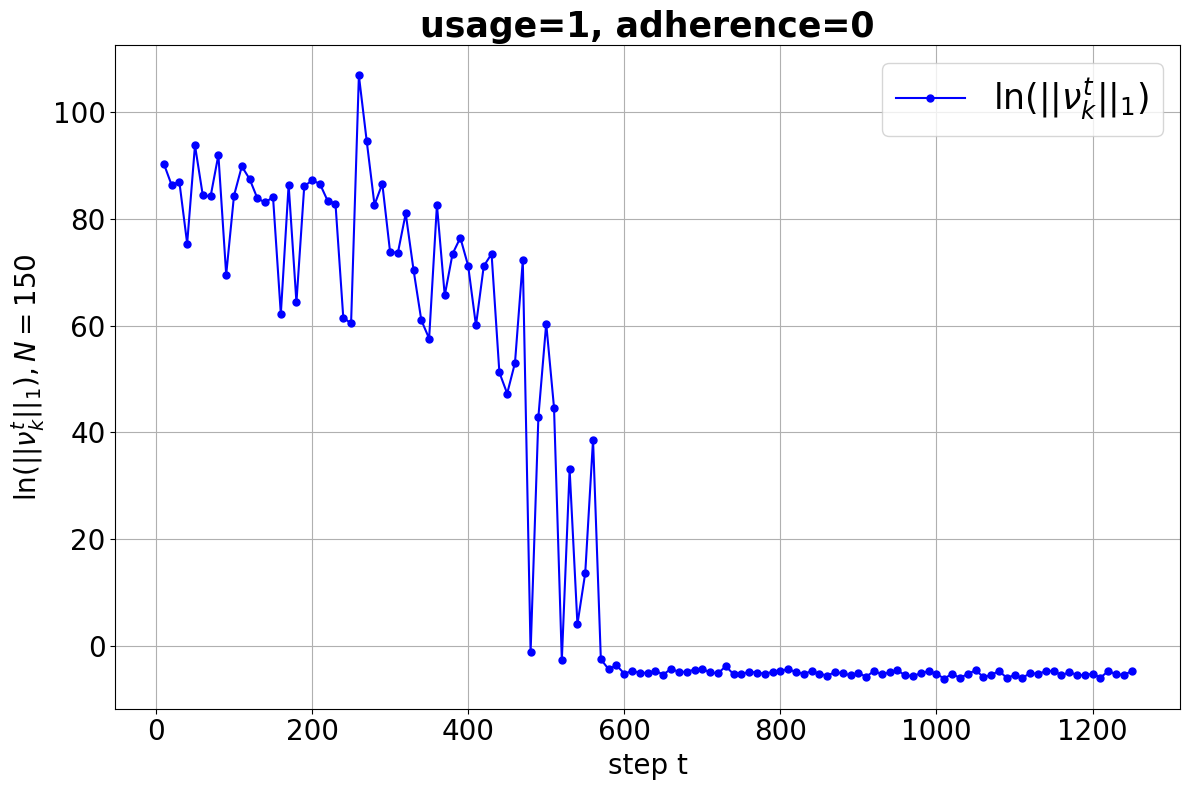

In [22]:
# plot ||moment_k^t||_1
plt.title(f"usage={usage}, adherence={adherence}")

plt.xlabel("step t")
plt.ylabel(r"$\ln(||\nu_k^t||_1), N = %i$" % N)

plt.plot(steps, np.log(l1_norms), label = r"$\ln(||\nu_k^t||_1)$", 
         color='blue', marker='o', markersize=5)

plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig(f"figures/moments_loop_{usage}_{adherence}.png")
plt.show()